# Dataset
This notebook implements the reading and generation of files for the dataset:
- BOOKS
- ELRA-W0246

# Import Cell

In [ ]:
! pip install langdetect 
! pip install swifter
! pip install translate-toolkit
! pip install rank_bm25  #https://github.com/dorianbrown/rank_bm25

In [1]:
from glob import glob
import os

import pandas as pd
import swifter

import numpy as np
from rank_bm25 import BM25Okapi
from matplotlib import pyplot as plt 

from tqdm.notebook import tnrange, tqdm_notebook

import torch
from torch.distributions.multinomial import Multinomial
from torch.nn import CosineSimilarity
import torch.nn.functional as F
from langdetect import detect
from torchtext.vocab import GloVe
import string

from translate.storage.tmx import tmxfile # http://docs.translatehouse.org/projects/translate-toolkit/en/latest/api/storage.html#module-translate.storage.tmx

%matplotlib inline

# Reading books Dataset http://opus.nlpl.eu/Books.php
- Cite this http://opus.nlpl.eu/LREC2012.txt

In [5]:
# download books
! wget -nc -O /work/datasets/books/books.tmx.gz http://opus.nlpl.eu/download.php?f=Books/v1/tmx/en-pt.tmx.gz
! gunzip /work/datasets/books/books.tmx.gz

--2020-06-02 12:49:56--  http://opus.nlpl.eu/download.php?f=Books/v1/tmx/en-pt.tmx.gz
Resolving opus.nlpl.eu (opus.nlpl.eu)... 193.166.25.9
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://object.pouta.csc.fi/OPUS-Books/v1/tmx/en-pt.tmx.gz [following]
--2020-06-02 12:49:59--  https://object.pouta.csc.fi/OPUS-Books/v1/tmx/en-pt.tmx.gz
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.19, 86.50.254.18
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118545 (116K) [application/gzip]
Saving to: ‘/work/datasets/books/books.tmx.gz’

/work/datasets/book 100%[===================>] 115.77K   224KB/s    in 0.5s    

2020-06-02 12:50:02 (224 KB/s) - ‘/work/datasets/books/books.tmx.gz’ saved [118545/118545]



In [7]:
with open("/work/datasets/books/books.tmx", 'rb') as fin:
     tmx_file = tmxfile(fin, 'en', 'pt')

In [8]:
eng_books = []; pt_books = []
for node in tmx_file.unit_iter():
    eng_books.append(node.getsource())
    pt_books.append(node.gettarget())

In [9]:
eng_books[0]

"ALICE'S ADVENTURES IN WONDERLAND"

In [10]:
pt_books[0]

'Alice no País das Maravilhas'

## Analyzing books Dataset with panda

In [11]:
books = pd.DataFrame((zip(eng_books, pt_books)), 
               columns =['ENG', 'PT']) 

In [12]:
books.describe()

,ENG,PT
count,1398,1398
unique,1397,1391
top,"Will you, won't you, will you, won't you, will...","Você vai, você não, você vai, você não, você n..."
freq,2,3


In [13]:
# Removing duplicates
books = books.drop_duplicates(subset='ENG', keep="first")
books = books.drop_duplicates(subset='PT', keep="first")

In [14]:
books.describe()

,ENG,PT
count,1391,1391
unique,1391,1391
top,'It all came different!' the Mock Turtle repea...,Uma roseira grande erguia-se perto da entrada ...
freq,1,1


In [15]:
# Checking length of each sentence on the dataset
books['ENG_LENGTH'] = books.apply( lambda row: len(row['ENG'].split()),axis=1)
books['PT_LENGTH']  = books.apply( lambda row: len(row['PT'].split()),axis=1)

In [16]:
# drop to small sentences (size < 15)
books = books.mask(books.ENG_LENGTH < 15 ).dropna()
books = books.mask(books.PT_LENGTH < 15 ).dropna()

In [17]:
books.describe()

,ENG_LENGTH,PT_LENGTH
count,600.000000,600.000000
mean,32.160000,31.068333
std,18.097429,17.275737
min,15.000000,15.000000
25%,21.000000,20.000000
50%,27.000000,26.000000
75%,38.000000,37.000000
max,179.000000,163.000000


In [18]:
# Remove sentence that are on another language
from langdetect import detect
books['ENG_LANG'] = books.swifter.apply( lambda row: detect(row['ENG']) == 'en', axis=1)
books['PT_LANG']  = books.swifter.apply( lambda row: detect(row['PT']) == 'pt',axis=1)

In [19]:
# drop to wrong language assigned
books = books.mask(books.ENG_LANG == False ).dropna()
books = books.mask(books.PT_LANG == False ).dropna()

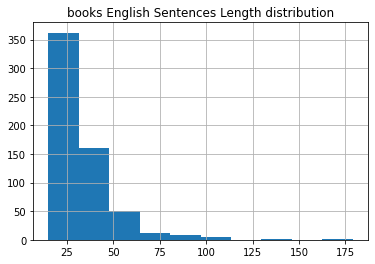

count    600.000000
mean      32.160000
std       18.097429
min       15.000000
25%       21.000000
50%       27.000000
75%       38.000000
max      179.000000
Name: ENG_LENGTH, dtype: float64

In [20]:
books['ENG_LENGTH'].hist()
plt.title("books English Sentences Length distribution")
plt.show()
books['ENG_LENGTH'].describe()

We can notice that 75% of the sentence has length less then 360

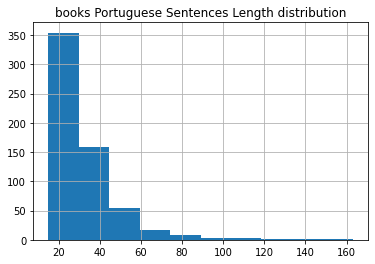

count    600.000000
mean      31.068333
std       17.275737
min       15.000000
25%       20.000000
50%       26.000000
75%       37.000000
max      163.000000
Name: PT_LENGTH, dtype: float64

In [21]:
books['PT_LENGTH'].hist()
plt.title("books Portuguese Sentences Length distribution")
plt.show()
books['PT_LENGTH'].describe()

# Paraphrase Process
We did manually the paraphrases on eng and pt, using the bellow sites:
Query phrases to:
- [ENG] "https://www.paraphrase-online.com/"
- [PT] "https://smodin.me/pt/automaticamente-reescreva-texto-em-portugu%C3%AAs-gratuitamente"



In [22]:
# download dataset with paraphases

! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=19NOQ6mab7_9jzZvAxF8lp3dEqpFoSOka' -O /work/datasets/books/books_test.pckl


--2020-06-02 12:50:45--  https://docs.google.com/uc?export=download&id=19NOQ6mab7_9jzZvAxF8lp3dEqpFoSOka
Resolving docs.google.com (docs.google.com)... 172.217.28.14, 2800:3f0:4001:810::200e
Connecting to docs.google.com (docs.google.com)|172.217.28.14|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d9laef71kjeft56f38no2oilh1arq5ii/1591102200000/03284941598352038832/*/19NOQ6mab7_9jzZvAxF8lp3dEqpFoSOka?e=download [following]
--2020-06-02 12:50:46--  https://doc-0k-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d9laef71kjeft56f38no2oilh1arq5ii/1591102200000/03284941598352038832/*/19NOQ6mab7_9jzZvAxF8lp3dEqpFoSOka?e=download
Resolving doc-0k-4o-docs.googleusercontent.com (doc-0k-4o-docs.googleusercontent.com)... 172.217.162.193, 2800:3f0:4001:818::2001
Connecting to doc-0k-4o-docs.googleusercontent.com (doc-0k-4o-docs.googleus

In [23]:
#paraphase on https://paraphrasing-tool.com/
books_with_paraphrases = pd.read_pickle("/work/datasets/books/books_test.pckl")

In [24]:
books_with_paraphrases

,ENG,PT,paraphrase-pt,paraphrase-eng
0,Alice was beginning to get very tired of sitti...,Alice estava começando a ficar muito cansada d...,Alice começou a se cansar de sentar no banco a...,Alice was starting to urge exceptionally tired...
1,So she was considering in her own mind (as wel...,"Então, ela pensava consigo mesma (tanto quanto...",Então ela pensou sobre isso (quando o clima qu...,So she was considering in her claim intellect ...
2,There was nothing so very remarkable in that; ...,Não havia nada de tão extraordinário nisso; ne...,Nada é especial. Alice não ouviu o coelho dize...,There was nothing so exceptionally momentous i...
3,I shall be late!' (when she thought it over af...,Irei me atrasar! (quando refletiu sobre isso d...,Eu vou me atrasar! ((Quando ele pensou sobre i...,I should be late!' (when she thought it over a...
4,"In another moment down went Alice after it, ne...","Logo depois Alice desceu atrás dele, em moment...","Logo depois, Alice ficou atrás dele, nunca pen...","In another minute down went Alice after it, ne..."
...,...,...,...,...
595,"But her sister sat still just as she left her,...",Mas a irmã sentou ainda assim que ela tinha le...,"Mas quando ela se levantou, estava sentada qui...",But her sister sat still fair as she cleared o...
596,"First, she dreamed of little Alice herself, an...","Primeiro, ela sonhou com a própria pequena Ali...","Primeiro, ela sonhou com o que sua pequena Ali...","To begin with, she envisioned of small Alice h..."
597,The long grass rustled at her feet as the Whit...,O longo gramado farfalhou em seus pés enquanto...,"Enquanto o coelho branco corria, um longo gram...",The long grass stirred at her feet as the Whit...
598,"So she sat on, with closed eyes, and half beli...","Então ela se sentou, com os olhos fechados, e ...","Então ela se sentou e fechou os olhos, metade ...","So she sat on, with closed eyes, and half acce..."


In [25]:
books_with_paraphrases.describe()

,ENG,PT,paraphrase-pt,paraphrase-eng
count,600,600,600,600
unique,600,600,600,600
top,"Alice had no idea what to do, and in despair s...",Uma roseira grande erguia-se perto da entrada ...,A principal dificuldade que Alice encontrou in...,"In a small whereas, be that as it may, she onc..."
freq,1,1,1,1


# Negatives Sentences from http://opus.nlpl.eu/ELRA-W0246.php
- cite this: http://opus.nlpl.eu/LREC2012.txt

After adding more paraphrases to the books dataset, we need to have some negatives sentences to compare it.
For this we are using the ELRA-W0246 dataset

In [26]:
# download ELRA-W0246 dataset 
! wget -nc -O /work/datasets/books/ELRA-W0246.tmx.gz http://opus.nlpl.eu/download.php?f=ELRA-W0246/v1/tmx/en-pt.tmx.gz
! gunzip /work/datasets/books/ELRA-W0246.tmx.gz

--2020-06-02 12:51:10--  http://opus.nlpl.eu/download.php?f=ELRA-W0246/v1/tmx/en-pt.tmx.gz
Resolving opus.nlpl.eu (opus.nlpl.eu)... 193.166.25.9
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://object.pouta.csc.fi/OPUS-ELRA-W0246/v1/tmx/en-pt.tmx.gz [following]
--2020-06-02 12:51:10--  https://object.pouta.csc.fi/OPUS-ELRA-W0246/v1/tmx/en-pt.tmx.gz
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126782 (124K) [application/gzip]
Saving to: ‘/work/datasets/books/ELRA-W0246.tmx.gz’

/work/datasets/book 100%[===================>] 123.81K   240KB/s    in 0.5s    

2020-06-02 12:51:12 (240 KB/s) - ‘/work/datasets/books/ELRA-W0246.tmx.gz’ saved [126782/126782]

gzip: /work/datasets/books/ELRA-W0246.tmx already exists; do you wis

In [27]:
with open("/work/datasets/books/ELRA-W0246.tmx", 'rb') as fin:
     tmx_file = tmxfile(fin, 'en', 'pt')
eng_neg = []; pt_neg = []
for node in tmx_file.unit_iter():
    eng_neg.append(node.getsource())
    pt_neg.append(node.gettarget())
    
ELRA = pd.DataFrame((zip(eng_neg, pt_neg)), 
               columns =['ENG', 'PT']) 

In [28]:
ELRA

,ENG,PT
0,PREAMBLE,PREÂMBULO
1,On the 25th of April 1974 the Armed Forces Mov...,"A 25 de Abril de 1974, o Movimento das Forças ..."
2,"Freeing Portugal from dictatorship, oppression...","Libertar Portugal da ditadura, da opressão e d..."
3,The Revolution restored their fundamental righ...,A Revolução restituiu aos Portugueses os direi...
4,"In the exercise of those rights and freedoms, ...","No exercício destes direitos e liberdades, os ..."
...,...,...
1480,Article 295(Referenda on European treaties),Artigo 295.º(Referendo sobre tratado europeu)
1481,The provisions of Article 115(3) do not prejud...,O disposto no n.º 3 do artigo 115.º não prejud...
1482,Article 296(Date and entry into force of the C...,Artigo 296.º(Data e entrada em vigor da Consti...
1483,1. The Constitution of the Portuguese Republic...,1. A Constituição da República Portuguesa tem ...


In [29]:
# Removing duplicates
ELRA = ELRA.drop_duplicates(subset='ENG', keep="first")
ELRA = ELRA.drop_duplicates(subset='PT', keep="first")

In [30]:
ELRA.describe()

,ENG,PT
count,1485,1485
unique,1485,1485
top,2. During his absence or inability to perform ...,2. Os restantes membros do Governo são nomeado...
freq,1,1


In [31]:
# Checking length of each sentence on the dataset
ELRA['ENG_LENGTH'] = ELRA.apply( lambda row: len(row['ENG'].split()),axis=1)
ELRA['PT_LENGTH']  = ELRA.apply( lambda row: len(row['PT'].split()),axis=1)

# drop to small sentences (size < 15)
ELRA = ELRA.mask(ELRA.ENG_LENGTH < 15 ).dropna()
ELRA = ELRA.mask(ELRA.PT_LENGTH < 15 ).dropna()
ELRA.describe()

,ENG_LENGTH,PT_LENGTH
count,875.000000,875.000000
mean,32.645714,29.200000
std,14.144731,11.955294
min,15.000000,15.000000
25%,22.000000,20.000000
50%,29.000000,26.000000
75%,39.000000,35.000000
max,112.000000,89.000000


In [32]:
# Remove sentence that are on another language
from langdetect import detect
ELRA['ENG_LANG'] = ELRA.swifter.apply( lambda row: detect(row['ENG']) == 'en', axis=1)
ELRA['PT_LANG']  = ELRA.swifter.apply( lambda row: detect(row['PT']) == 'pt',axis=1)

In [33]:
# drop to wrong language assigned
ELRA = ELRA.mask(ELRA.ENG_LANG == False ).dropna()
ELRA = ELRA.mask(ELRA.PT_LANG == False ).dropna()

In [34]:
ELRA.describe()

,ENG_LENGTH,PT_LENGTH
count,875.000000,875.000000
mean,32.645714,29.200000
std,14.144731,11.955294
min,15.000000,15.000000
25%,22.000000,20.000000
50%,29.000000,26.000000
75%,39.000000,35.000000
max,112.000000,89.000000


In [35]:
ELRA = ELRA.drop(['ENG_LENGTH','PT_LENGTH','ENG_LANG','PT_LANG'],axis=1)

In [36]:
ELRA.describe()

,ENG,PT
count,875,875
unique,875,875
top,1. Without prejudice to the suspension or term...,2. Os restantes membros do Governo são nomeado...
freq,1,1


In [37]:
ELRA.to_pickle("/work/datasets/books/ELRA.pckl")

# Getting the most similar sentence from ELRA and BOOKS dataset, and mark then as negatives

For this propose we are using two feature:
- consine_similarity between the sentence embedding of each sentences of the both dataset.
- BM25 score for each query sentence of Book on the corpus ELRA

# Loading Glove Vectors to use as word embedding

### Glove Portuguese
-http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

Load glove

In [ ]:
#Download embedding and glove_br dict
! wget -nc -O /work/src/Dataset-Construction-Notebook/glove_br/glove_s50.zip http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s50.zip
! unzip /work/src/Dataset-Construction-Notebook/glove_br/glove_s50.zip

In [38]:
glove_dict_pt ={}
vectors_pt = []
with open("/work/src/Dataset-Construction-Notebook/glove_br/glove_s50.txt", 'r') as file:
    nlines, dim  = file.readline().split()
    dim = int(dim)
    nlines = int(nlines)
    for index in tnrange(nlines):
        line = file.readline().split()
        token = " ".join(line[0:-dim])
        glove_dict_pt[token] = index
        vectors_pt.append([float(val) for val in line[-dim:]])
vectors_pt = torch.tensor(vectors_pt)

In [39]:
# glove_vectors is a pytorch vocabulary
# https://github.com/pytorch/text/blob/master/torchtext/vocab.py
glove_vectors = GloVe(name='6B', dim=50, cache='/work/glove_dir')

vectors_eng = glove_vectors.vectors
glove_dict_eng = glove_vectors.stoi

### Creating Torch Tensors from the words

In [40]:
eng_book  = books_with_paraphrases["ENG"].values
eng_book_paraphrase  = books_with_paraphrases["paraphrase-eng"].values
pt_book  = books_with_paraphrases["PT"].values
pt_book_paraphrase  = books_with_paraphrases["paraphrase-pt"].values

# negatives
erla_eng = ELRA["ENG"].values
erla_pt = ELRA["PT"].values

In [41]:
table = str.maketrans({key: None for key in string.punctuation})
def remove_punctuation(sentence):
    return sentence.translate(table)

def get_sentence_embedding(sentence,vec,dict_glove,dim=50):
    """
    From a input sentence, calculate a sentence embedding.
    The sentence embedding is the mean of each word embedding beloging to the sentence.
    """
    
    # Remove punctuation from the sentence
    sentence = remove_punctuation(sentence)
    
    # Calculate the mean for each word embedding beloging to the sentence
    list_of_embedding =  [ vec[dict_glove[word]] 
                             for word in sentence.split()
                             if (word in dict_glove)
                         ]
    
    # if we could not find any word in the sentence that is in the vocabulary
    # we return a random value
    if list_of_embedding == []:
        print("FALSE")
        return torch.rand(dim)
        
    # return the sentence embedding mean
    return torch.mean( torch.stack( list_of_embedding) ,axis=0)

In [42]:
eng_book_vectors = []
for sentence in tqdm_notebook(eng_book):
    eng_book_vectors.append(get_sentence_embedding(sentence,vectors_eng,glove_dict_eng))
eng_book_vectors = torch.stack(eng_book_vectors)

eng_book_para_vectors = []
for sentence in tqdm_notebook(eng_book_paraphrase):
    eng_book_para_vectors.append(get_sentence_embedding(sentence,vectors_eng,glove_dict_eng))
eng_book_para_vectors = torch.stack(eng_book_para_vectors)

eng_elra_neg_vectors = []
for sentence in tqdm_notebook(erla_eng):
    eng_elra_neg_vectors.append(get_sentence_embedding(sentence,vectors_eng,glove_dict_eng))
eng_elra_neg_vectors = torch.stack(eng_elra_neg_vectors)

In [44]:
pt_book_vectors = []
for sentence in tqdm_notebook(pt_book):
    pt_book_vectors.append(get_sentence_embedding(sentence,vectors_pt,glove_dict_pt))
pt_book_vectors = torch.stack(pt_book_vectors)

pt_book_para_vectors = []
for sentence in tqdm_notebook(pt_book_paraphrase):
    pt_book_para_vectors.append(get_sentence_embedding(sentence,vectors_pt,glove_dict_pt))
pt_book_para_vectors = torch.stack(pt_book_para_vectors)

pt_elra_neg_vectors = []
for sentence in tqdm_notebook(erla_pt):
    pt_elra_neg_vectors.append(get_sentence_embedding(sentence,vectors_pt,glove_dict_pt))
pt_elra_neg_vectors = torch.stack(pt_elra_neg_vectors)

## BM25 Score

In [45]:
# ERLA PT
corpus = erla_pt
tokenized_corpus = [doc.split(" ") for doc in corpus]
pt_elra_bm25 = BM25Okapi(tokenized_corpus)

# ERLA ENG
corpus = erla_eng
tokenized_corpus = [doc.split(" ") for doc in corpus]
eng_elra_bm25 = BM25Okapi(tokenized_corpus)

In [53]:
from torch.nn import CosineSimilarity

cos = CosineSimilarity()

def find_most_similar_cross_data(query_vec, tensors, bm25_model, querry_sentence, top_k=20):
    """
    User cosine similarity with bm25 score to retrieve the most similar sentences
    """
    # Reshape query 
    query_vec = query_vec.unsqueeze(0)
    # Apply cosine similarity between the query and all dataset
    cosine_similarity_between_query_tensors = cos(query_vec,tensors)
    
    # BM25_Score
    tokenized_query = querry_sentence.split(" ")

    scores = bm25_model.get_scores(tokenized_query)
    
    #Normalize score
    scores = torch.tensor(scores / np.linalg.norm(scores))
    
    mix_scores = cosine_similarity_between_query_tensors + 2*scores
    
    # Sort values by similarity: The highest similarity is 1 and lowest -1
    values, indeces = mix_scores.topk(top_k)
    
    # Get Random sentence that are inside the top_50
    sampling = Multinomial(total_count=1,logits=values).sample()
    
    # Retrieve selected sentence
    most_similar = indeces.masked_select(sampling.type(torch.bool))
    
    # Return the top_5 similar result, after the sampling
    return most_similar

def find_most_similar(query, tensors,index,top_k=200):
    """
    Retrieve most similar sentences
    """
    # Reshape query 
    query = query.unsqueeze(0)
    # Apply cosine similarity between the query and all dataset
    cosine_similarity_between_query_tensors = cos(query,tensors)
    
    # Sort values by similarity: The highest similarity is 1 and lowest -1
    values, indeces = cosine_similarity_between_query_tensors.topk(top_k)
    
    # Get Random sentence that are inside the nucleues
    sampling = Multinomial(total_count=10,logits=values).sample()
    
    # Retrieve selected sentence
    most_similar = indeces.masked_select(sampling.type(torch.bool))
    # remove the translation of the query from the selected ones ( if it is there)
    most_similar = most_similar[most_similar != index]
    
    # Return the 5th similar result, after the sampling
    return most_similar[5]

In [61]:
negative_sentence = {
    'pt_books__pt_erla': [],
    'pt_books_paraphrase__pt_erla': [],
    'eng_books__eng_erla': [],
    'eng_books_paraphrase__eng_erla': [],
    'top_1_qeng_pt': [],
    'top_1_qpt_eng': [],
}
total = len(books_with_paraphrases)
for index in tnrange(total):
    
    # Most lexical similar sentence from pt_books to pt_erla
    qpt_index = find_most_similar_cross_data(pt_book_vectors[index],
                                  pt_elra_neg_vectors,
                                  pt_elra_bm25,
                                  pt_book[index])
    
    negative_sentence['pt_books__pt_erla'].append(erla_pt[qpt_index])
    
    # Most lexical similar sentence from pt_books_paraphrase to pt_erla
    qpt_index = find_most_similar_cross_data(pt_book_para_vectors[index],
                                  pt_elra_neg_vectors,
                                  pt_elra_bm25,
                                  pt_book_paraphrase[index])
    negative_sentence['pt_books_paraphrase__pt_erla'].append(erla_pt[qpt_index])
    
    
    # Most lexical similar sentence from eng_books to eng_erla
    qeng_index = find_most_similar_cross_data(eng_book_vectors[index],
                                  eng_elra_neg_vectors,
                                  eng_elra_bm25,
                                  eng_book[index])
    negative_sentence['eng_books__eng_erla'].append(erla_eng[qeng_index])
    
    # Most lexical similar sentence from eng_books_paraphrase to eng_erla
    qeng_index = find_most_similar_cross_data(eng_book_para_vectors[index],
                                  eng_elra_neg_vectors,
                                  eng_elra_bm25,
                                  eng_book_paraphrase[index])
    negative_sentence['eng_books_paraphrase__eng_erla'].append(erla_eng[qeng_index])
    
    # Most lexical similar sentence from pt_books to eng_books_paraphrase
    qpt_index = find_most_similar( pt_book_vectors[index],
                                   eng_book_para_vectors,
                                  index)
    negative_sentence['top_1_qpt_eng'].append(eng_book_paraphrase[qpt_index])
    
    # Most lexical similar sentence from eng_books to pt_book_paraphrase
    qeng_index = find_most_similar( eng_book_vectors[index],
                                    pt_book_para_vectors,
                                    index)
    negative_sentence['top_1_qeng_pt'].append(pt_book_paraphrase[qeng_index])




In [62]:
books_with_paraphrases['pt_books__pt_erla'] = negative_sentence['pt_books__pt_erla']
books_with_paraphrases['pt_books_paraphrase__pt_erla'] = negative_sentence['pt_books_paraphrase__pt_erla']
books_with_paraphrases['eng_books__eng_erla'] = negative_sentence['eng_books__eng_erla']
books_with_paraphrases['eng_books_paraphrase__eng_erla'] = negative_sentence['eng_books_paraphrase__eng_erla']
books_with_paraphrases['top_1_qpt_eng'] = negative_sentence['top_1_qpt_eng']
books_with_paraphrases['top_1_qeng_pt'] = negative_sentence['top_1_qeng_pt']


In [65]:
books_with_paraphrases.to_pickle("/work/datasets/books/TESTSET.pkl")

# Conclusions

In [2]:
books_with_paraphrases = pd.read_pickle("/work/datasets/books/TESTSET.pkl")

In [4]:
books_with_paraphrases.sample().values

array([["'Oh, I beg your pardon!' cried Alice hastily, afraid that she had hurt the poor animal's feelings. 'I quite forgot you didn't like cats.'",
        'O Rato deu um salto repentino para fora da água e pareceu estremecer-se todo de medo. - Oh, desculpe-me!, gritou Alice depressa, com medo de ter ferido os sentimentos do pobre animal. - Eu quase esqueci que você não gosta de gatos.',
        'O rato pulou de repente da água, parecendo tremer de medo. - Oh, desculpe!, Exclamou Alice rapidamente, com medo de ferir os sentimentos desse pobre animal. - Eu quase esqueci que você não gosta de gatos.',
        "'Oh, I ask your pardon!' cried Alice hurriedly, perplexed that she had harmed the destitute animal's sentiments. 'I very overlooked you didn't like cats.'",
        '2. Os partidos políticos representados na Assembleia da República, e que não façam parte do Governo, têm direito, nos termos da lei, a tempos de antena no serviço público de rádio e televisão, a ratear de acordo com a

In [67]:
books_with_paraphrases.describe()

,ENG,PT,paraphrase-pt,paraphrase-eng,pt_books__pt_erla,pt_books_paraphrase__pt_erla,eng_books__eng_erla,eng_books_paraphrase__eng_erla,top_1_qpt_eng,top_1_qeng_pt
count,600,600,600,600,600,600,600,600,600,600
unique,600,600,600,600,207,221,216,214,190,161
top,"Alice had no idea what to do, and in despair s...",Uma roseira grande erguia-se perto da entrada ...,A principal dificuldade que Alice encontrou in...,"In a small whereas, be that as it may, she onc...","7. Sem prejuízo do disposto no n.º 1, o Presid...",3. O arguido tem direito a escolher defensor e...,I swear by my honour to faithfully perform the...,e) To pronounce on the other cases provided fo...,"She carried the pepper-box in her hand, and Al...",Uma vez que ela era pequena o suficiente para ...
freq,1,1,1,1,15,12,18,19,10,14


In [64]:
books_with_paraphrases.sample().values

array([['Then again--"before she had this fit--" you never had fits, my dear, I think?\' he said to the Queen.',
        "Por outro lado...'antes ela tinha forma...' você nunca teve forma, minha querida, não é? ele disse para a Rainha.",
        'Por outro lado ... Antes que tome forma ... Querida, você nunca tomou forma, certo? Ele disse para a rainha.',
        'At that point again--"before she had this fit--" you never had fits, my expensive, I think?\' he said to the Ruler.',
        '3. Se a moção de censura não for aprovada, os seus signatários não podem apresentar outra durante a mesma sessão legislativa.',
        '1. A Assembleia da República tem as comissões previstas no Regimento e pode constituir comissões eventuais de inquérito ou para qualquer outro fim determinado.',
        '1. Every citizen has the right of access to all computerised data that concern him, which he may require to be corrected and updated, and the right to be informed of the purpose for which they are i

This dataset was created just to test propose. Do not use this data to train.
For each sentence from ENG and PT we manually created it's paraphrase version. Also, we find another dataset to get the negative sentences, that are lexically similar to the ENG, PT sentence but very different in its semantics.